<h1 style="color:rgb(0,120,170)">Scaling and Projection Methods</h1>

<h2 style="color:rgb(0,120,170)">Task 1: SNE and t-SNE</h2> 

This assignment is about projection methods, which aim to reduce dimensionality of the data in a way such that the main characteristics of the data are preserved. This means we can take some data that lives in a high-dimensional space (such as images, which usually consist of thousands of pixels), and visualise them in a lower-dimensional space. In the first task, we will mainly focus on t-SNE, as it is arguably the most popular one of these methods. The aim is to implement the algorithm from scratch in numpy, which (hopefully) increases the understanding of its main building blocks.
Let us start by fixing some notation and introduce SNE (= stochastic neighbor embedding), where we stick to the convention from the lecture: 

* Data points $\mathbf{x}_1,...,\mathbf{x}_n \in \mathbb{R}^d$ in original space. We collect them in a data matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$
* The similarity of data point $\mathbf{x}_j$ to data point $\mathbf{x}_i$ is the conditional probability, $p_{j\mid i}$, that $\mathbf{x}_i$ would pick $\mathbf{x}_j$ as its neighbor.
* For observations $\{\mathbf{x}_1,\ldots,\mathbf{x}_n\}$, neighbors are picked in proportion to their probability density under a Gaussian centered at $\mathbf{x}_i$:
$$
p_{j|i} \ = \ \frac{\exp(-\lVert \mathbf{x}_i \ - \ \mathbf{x}_j\rVert^2 /
  2\sigma_i^2)}{\sum_{k \neq i} \exp(-\lVert
\mathbf{x}_i \ - \ \mathbf{x}_k\rVert^2 / 2\sigma_i^2)} \qquad  (\text{A})
$$
The choice of the $\sigma_i$s will be explained later. We also set $p_{i\mid i}=0$.
* For the low-dimensional projections $\mathbf{y}_i$ and $\mathbf{y}_j$ of the observations $\mathbf{x}_i$ and $\mathbf{x}_j$, a similar conditional probability is computed and denoted by $q_{j\mid i}$:
\begin{align}
q_{j|i} \ &= \ \frac{\exp(-\lVert \mathbf{y}_i \ - \ \mathbf{y}_j\rVert^2)}
{\sum_{k \neq i} \exp(-\lVert
\mathbf{y}_i \ - \ \mathbf{y}_k\rVert^2)} \ ,
\end{align}
where the variance is $1/\sqrt{2}$ and again $q_{i\mid i}=0$. The projected data points are again collected in a matrix $\mathbf{Y}$. In order to provide meaningful visualizations, we will project on a $2$-dimensional space, i.e. $\mathbf{Y}\in \mathbb{R}^{n \times 2}$. 

* Objective: KL-divergence between the distribution $\mathbf{P}$ and the distribution $\mathbf{Q}$:
\begin{align*}
C=KL(\mathbf{P}||\mathbf{Q}) = \ \sum_{i \neq j} p_{j|i} \log \frac{p_{j|i}}{q_{j|i}} \,
\end{align*}
which is minimized by Gradient descent wrt. $\mathbf{Y}$.

<h3 style="color:rgb(0,120,170)">Task:</h3> 

To start the implementation of t-SNE, let us compute the $p_{j|i}$'s. 
* Implement a function "neg_squared_euc_dists" containing negative squared euclidean distance for all pairs of points in input matrix $\mathbf{X}$.
* Furthermore, implement a function "calc_prob_matrix", that takes the (matrix of) negative pairwise distances and a vector consisting of the values of the $\sigma_i$'s as input and outputs the matrix $\mathbf{P}$ of the conditional probabilities $p_{j|i}$. To implement the softmax-function of the type $\frac{\exp()}{\sum \exp()}$ in (A) succesfully, please use the provided version for stability reasons (otherwise the code might not work properly).


<h3 style="color:rgb(210,90,80)">Code (10 points):</h3>

In [20]:
import numpy as np#
np.random.seed(42)
X = np.arange(0,12).reshape(3,4)
sum_X = np.sum(np.square(X), 1)
-np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)

array([[   0,  -64, -256],
       [ -64,    0,  -64],
       [-256,  -64,    0]])

In [21]:
import numpy as np

def softmax(X):
    """Take softmax of each row of matrix X."""

    # Subtract max for numerical stability
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

    # We usually want diagonal probabilities to be 0.
    np.fill_diagonal(e_x, 0.)

    # Add a tiny constant for stability of log which we take later
    e_x = e_x + 1e-8  # numerical stability

    return e_x / e_x.sum(axis=1).reshape([-1, 1])

################################
# Begin your code
def neg_squared_euc_dists(X):
    """Compute matrix containing negative squared euclidean
    distance for all pairs of points in input matrix X

    # Arguments:
        X: matrix of size NxD
    # Returns:
        NxN matrix D, with entry D_ij = negative squared
        euclidean distance between rows X_i and X_j
    """
    # Math? See https://stackoverflow.com/questions/37009647
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D

def calc_prob_matrix(distances, sigmas=None):
    """Convert a distances matrix to a matrix of probabilities."""
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)
# End your code
################################

The obvious next question is: how do we get the $\sigma_i$'s from above? This is where perplexity comes into play: The perplexity of any of the rows $\mathbf{P}_i$ of the conditional probabilities matrix $\mathbf{P}$ is defined as $\text{Perp}(\mathbf{P}_i)=\exp(H(\mathbf{P}_i))$.
Here $H(\mathbf{P}_i)$ is the Shannon entropy of $\mathbf{P}_i$: $H(\mathbf{P}_i)=−\sum_j p_{j|i} \log p_{j|i}$
In SNE (and t-SNE) perplexity is a parameter that we set (usually between 5 and 50). We then compute the $\sigma_i$'s such that for each row of $\mathbf{P}$, the perplexity of that row is equal to our desired perplexity.

Let us gain some further intuition: we already know that if a probability distribution has high entropy, it means that it is relatively flat, i.e., the probabilities of most of the elements in the distribution are around the same.

Perplexity increases with entropy. Thus, if we desire higher perplexity, we want all of the $p_{j|i}$ (for a given $i$) to be more similar to each other. In other words, we want the probability distribution $\mathbf{P}_i$ to be flatter. We can achieve this by increasing $\sigma_i$ – this acts just like the temperature parameter sometimes used in the softmax function. The larger the $\sigma_i$ we divide by, the closer the probability distribution gets to having all probabilities equal to just $1/n$.

Increasing $\sigma_i$s essentially increases the number of neighbours each point has (if we define $\mathbf{x}_i$ and $\mathbf{x}_j$ as neighbours if $p_{j|i}$ is below a certain probability threshold). This is why the perplexity parameter roughly corresponds to the number of neighbours we believe each point has.

To ensure that $\text{Perp}(\mathbf{P}_i)$ is equal to our desired perplexity, we simply perform a binary search over each $\sigma_i$.

This is possible because perplexity $\text{Perp}(\mathbf{P}_i)$ is a monotonically increasing function of $\sigma_i$.

Let us provide a basic binary search function in python:

In [22]:
def binary_search(eval_fn, target, tol=1e-10, max_iter=10000,
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = eval_fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess

We now need to pass an "eval_fn" to this "binary_search" function that takes a given $\sigma_i$ as its argument and returns the perplexity of $\mathbf{P}_i$ with that $\sigma_i$.

<h3 style="color:rgb(0,120,170)">Task:</h3> 

* Using the auxilary function "binary_search", compute a function "find_optimal_sigmas" that finds all $\sigma_i$’s in exactly the way described above: it should take a matrix of negative euclidean distances and a target perplexity. For each row of the distances matrix, it performs a binary search over possible values of $\sigma_i$ until finding the one which results in the target perplexity. It then returns a numpy vector containing the optimal $\sigma_i$’s that were found.

<h3 style="color:rgb(210,90,80)">Code (15 points):</h3>

In [23]:
################################
# Begin your code

def perplexity(distances, sigmas):
    """Wrapper function for quick calculation of 
    perplexity over a distance matrix."""
    prob_matrix = calc_prob_matrix(distances, sigmas)
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity

def find_optimal_sigmas(distances, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = [] 
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: perplexity(distances[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)

# End your code
################################

We now have everything we need to estimate SNE – we have $\mathbf{Q}$ and $\mathbf{P}$. We could find a decent 2D representation $\mathbf{Y}$ by descending the gradient of the cost $C$ with respect to $\mathbf{Y}$ until convergence.

Since the gradient of SNE is a little bit trickier to implement however, let us instead use Symmetric SNE.

In Symmetric SNE, we minimise a KL divergence over the joint probability distributions with entries $p_{ij}$ and $q_{ij}$, as opposed to conditional probabilities $p_{j|i}$ and $q_{j|i}$. Defining a joint distribution, each $q_{ij}$ is given by:


$$q_{ij} = \ \frac{\exp(-\lVert \mathbf{y}_i \ - \ \mathbf{y}_j\rVert^2)}
{\sum_{k \neq l} \exp(-\lVert
\mathbf{y}_l \ - \ \mathbf{y}_k\rVert^2)} \ ,
$$

This is just like the softmax we had before, except now the normalising term in the denominator is summed over the entire matrix, rather than just the current row. Let us collect the $q_{ij}$'s in a matrix $\mathbf{\tilde{Q}}$.

To avoid problems related to outlier $\mathbf{x}$-points, rather than using an analogous distribution for $p_{ij}$, we simply set $p_{ij}=\frac{p_{i|j}+p_{j|i}}{2n}$, thus the joint $\mathbf{\tilde{P}}$ is just $\frac{\mathbf{P}+\mathbf{P}^T}{2n}$, where $\mathbf{P}$ is the conditional probabilities matrix with entries $p_{i|j}$.

We now calculate these newly-defined joint distributions in Python. Let us first focus on $\mathbf{\tilde{P}}$ here:

<h3 style="color:rgb(0,120,170)">Task:</h3> 

* Compute a function "p_joint", that takes into account the data matrix $\mathbf{X}$ and the target perplexity and outputs the joint probabilities.

<h3 style="color:rgb(210,90,80)">Code (5 points):</h3>

In [24]:
################################
# Begin your code

def p_conditional_to_joint(P):
    """Given conditional probabilities matrix P, return
    approximation of joint distribution probabilities."""
    return (P + P.T) / (2. * P.shape[0])

def p_joint(X, target_perplexity):
    """Given a data matrix X, gives joint probabilities matrix.

    # Arguments
        X: Input data matrix.
    # Returns:
        P: Matrix with entries p_ij = joint probabilities.
    """
    # Get the negative euclidian distances matrix for our data
    distances = neg_squared_euc_dists(X)
    # Find optimal sigma for each row of this distances matrix
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    # Calculate the probabilities based on these optimal sigmas
    p_conditional = calc_prob_matrix(distances, sigmas)
    # Go from conditional to joint probabilities matrix
    P = p_conditional_to_joint(p_conditional)
    return P

# End your code
################################

As we focus on $\mathbf{\tilde{P}}$ and $\mathbf{\tilde{Q}}$ now, we also have a new objective:
$$
C=KL(\mathbf{\tilde{P}}||\mathbf{\tilde{Q}}) = \ \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}.
$$

For symmetric SNE, the only thing that remains is a formula for the gradient, which computes as follows:
\begin{align}   
\frac{\partial C}{\partial \mathbf{y}_i }=4\sum_j (p_{ij}−q_{ij})(\mathbf{y}_i−\mathbf{y}_j),
\end{align}
so that we can do Gradient descent as follows: $\mathbf{y}^t_i=\mathbf{y}^{t−1}_i−\eta \frac{\partial C}{\partial \mathbf{y}_i }$.
Let us put everything together in the next code snippet.

In [25]:
# Nothing to do

def q_symmetric_sne(Y):
    distances = neg_squared_euc_dists(Y)
    exp_distances = np.exp(distances)
    np.fill_diagonal(exp_distances, 0.)
    #Let us also output the distances for later purposes.
    return exp_distances / np.sum(exp_distances), None

def symmetric_sne_grad(P, Q, Y, _):
    pq_diff = P - Q  # NxN matrix
    pq_expanded = np.expand_dims(pq_diff, 2)  #NxNx1
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  #NxNx2
    grad = 4. * (pq_expanded * y_diffs).sum(1)  #Nx2
    return grad

def estimate_sne(X, P, num_iters=500, learning_rate=10):
    """Estimates a SNE model.
    # Arguments
        X: Input data matrix.
        P: Matrix of joint probabilities.
        num_iters: Iterations to train for.
        learning_rate
    # Returns:
        Y: Matrix, low-dimensional representation of X.
    """
        
    # Initialise our 2D representation
    Y = np.random.RandomState(1).normal(0., 0.001, [X.shape[0], 2])
    # Start gradient descent loop
    for i in range(num_iters):
        # Get Q and distances
        Q, distances = q_symmetric_sne(Y)
        # Estimate gradients with respect to Y
        grads = symmetric_sne_grad(P, Q, Y, distances)
        #Update Y
        Y = Y - learning_rate * grads
    return Y

To go from Symmetric SNE to t-SNE, the only real difference is how we define the joint probability distribution matrix $\mathbf{\tilde{Q}}$. In t-SNE, this changes as follows:

\begin{align}
q_{ij} = \ \frac{(1+\lVert \mathbf{y}_i \ - \ \mathbf{y}_j\rVert^2)^{-1}}
{\sum_{k \neq l} (1+\lVert
\mathbf{y}_l \ - \ \mathbf{y}_k\rVert^2)^{-1}} \ ,
\end{align}

It is assumed that the $q_{ij}$ follow a Student t-distribution with one degree of freedom. This distribution has the nice property that the numerator approaches an inverse square law for large distances in the low-dimensional space. Essentially, this means the algorithm is almost invariant to the general scale of the low-dimensional mapping. Thus the optimisation works in the same way for points that are very far apart as it does for points that are closer together.

This addresses the so-called ‘crowding problem:’ when we try to represent a high-dimensional dataset in two or three dimensions, it becomes difficult to separate nearby data points from moderately-far-apart data points – everything becomes crowded together, and this prevents the natural clusters in the dataset from becoming separated.

<h3 style="color:rgb(0,120,170)">Task:</h3> 

* Implement a function "q_tsne", that should output on the one hand the matrix of the $q_{ij}$'s, but on the other hand also a matrix consisting of the values $r_{ij}=(1+\lVert \mathbf{y}_i \ - \ \mathbf{y}_j\rVert^2)^{-1}$, i.e. the nominators of the $q_{ij}$'s (this will be useful for later purposes).

<h3 style="color:rgb(210,90,80)">Code (5 points):</h3>

In [26]:
################################
# Begin your code
def q_tsne(Y):
    """t-SNE: Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    distances = neg_squared_euc_dists(Y)
    inv_distances = np.power(1. - distances, -1)
    np.fill_diagonal(inv_distances, 0.)
    Q = inv_distances / np.sum(inv_distances)
    return Q , inv_distances

# End your code
################################

<h3 style="color:rgb(0,120,170)">Task:</h3> 

The only thing left to do now is compute the gradient of the cost with respect to $\mathbf{Y}$ for t-SNE. This will be your next task, i.e. you should obtain the following formula:

\begin{align}   
\frac{\partial C}{\partial \mathbf{y}_i }=4\sum_j (p_{ij}−q_{ij})(\mathbf{y}_i−\mathbf{y}_j)(1+\lVert
\mathbf{y}_i \ - \ \mathbf{y}_j\rVert^2)^{−1} \qquad (\text{B})
\end{align}
Hint:  
* To make notation easier, introduce $d_{ij}=\lVert \mathbf{y}_i \ - \ \mathbf{y}_j\rVert^2$ and $Z=\sum_{k \neq l}(1+d_{kl})^{-1}$. Argue that  $\frac{\partial C}{\partial \mathbf{y}_i }=4\sum_j \frac{\partial C}{\partial d_{ij} }(\mathbf{y}_i \ - \ \mathbf{y}_j)$ using the chain rule and symmetry.
* Now use the explicit formula for $C$ and the trick that $\log q_{kl}=\log q_{kl}Z-\log Z$ to get the correct formula for $\frac{\partial C}{\partial d_{ij} }$. Note that most of the terms in the appearing sums cancel after taking the derivative. Also the fact that $\sum_{k \neq l}p_{kl}=1$ might be useful.

<h3 style="color:rgb(208,90,80)">Calculation (20 Points):</h3>

Your solution here.

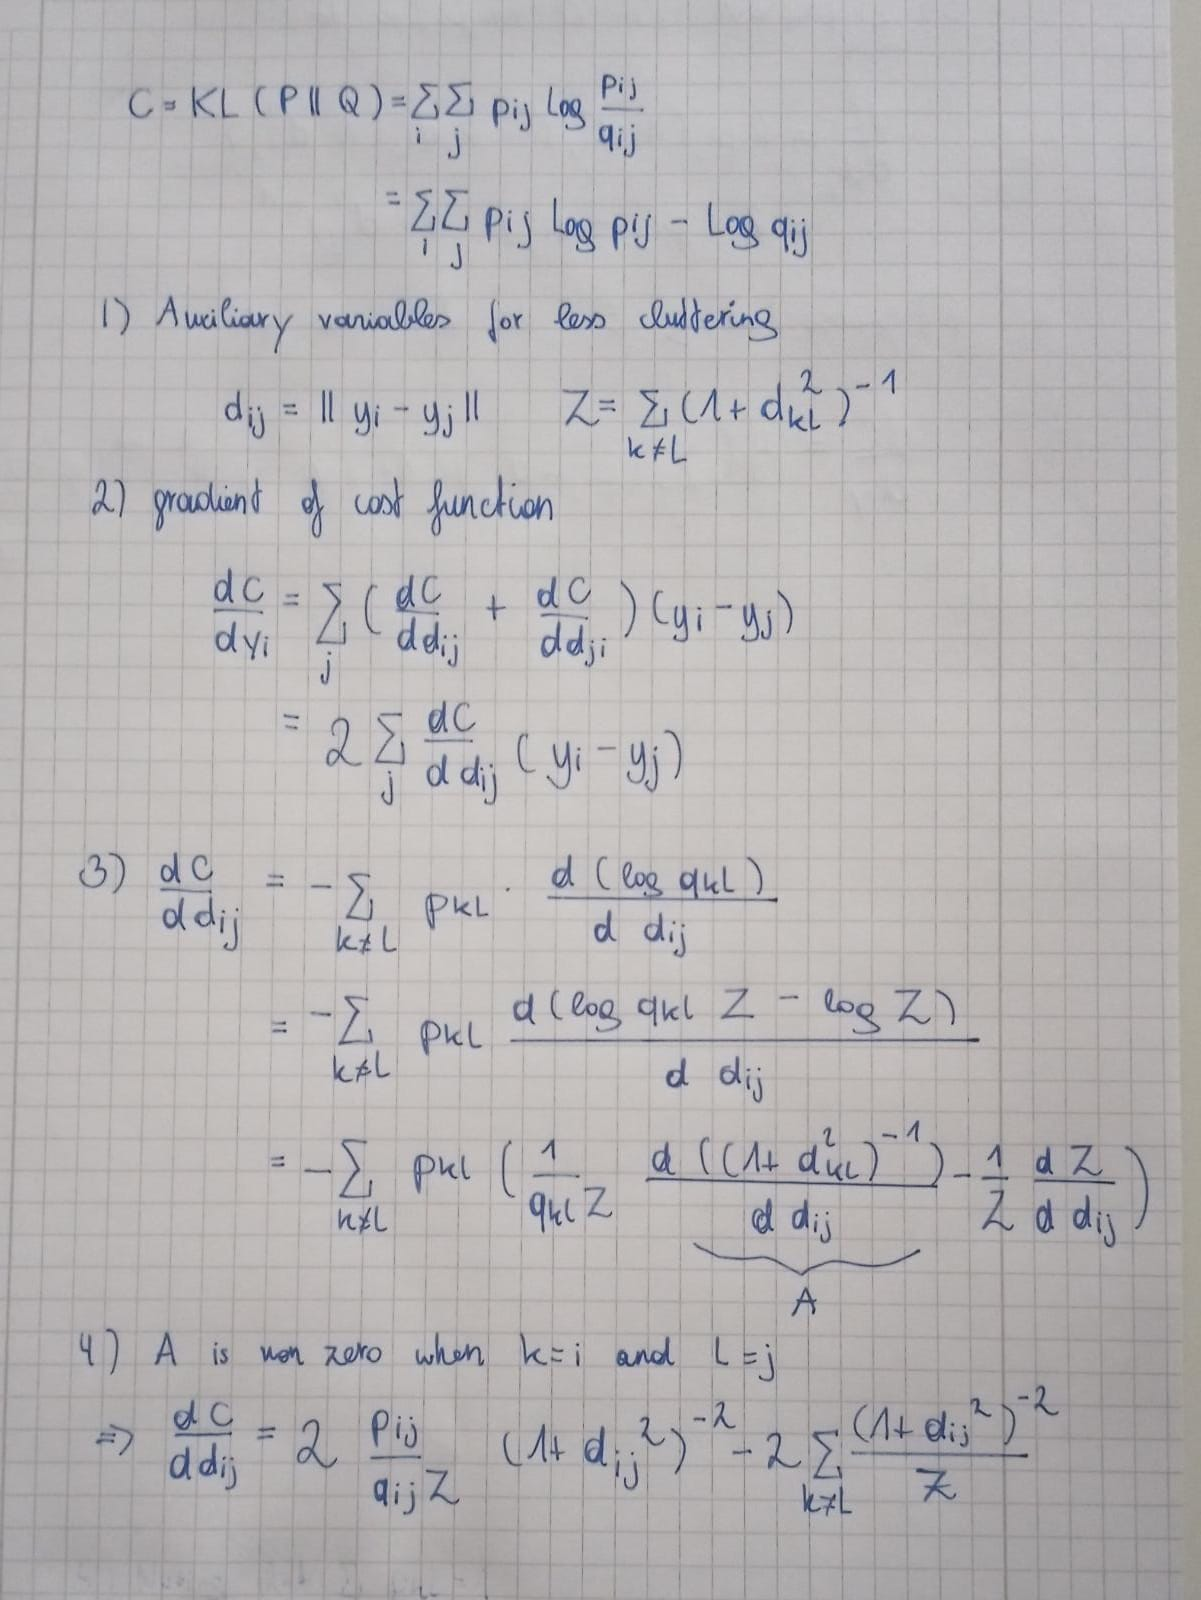

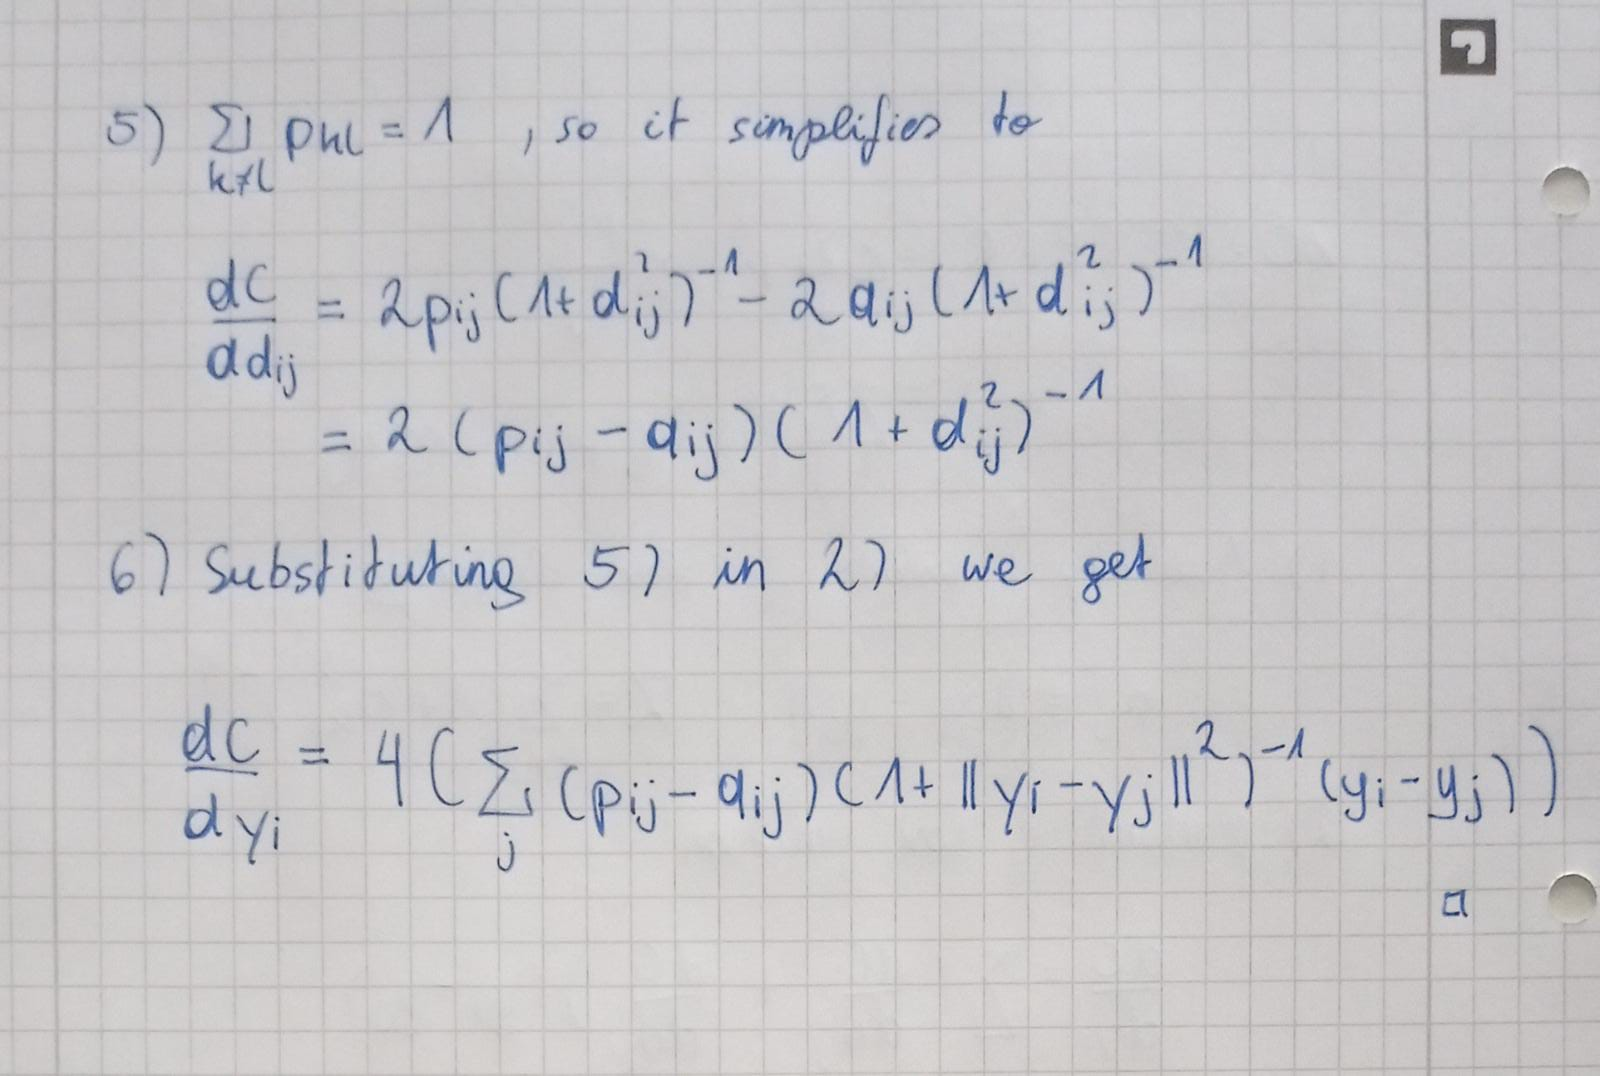

Now it is time to implement the formula for the gradient and put everything together.

<h3 style="color:rgb(0,120,170)">Task:</h3> 

* Implement a function "tsne_grad", that takes $\mathbf{\tilde{P}}$, $\mathbf{\tilde{Q}}$, $\mathbf{Y}$ and the matrix of the pairwise distances as inputs and outputs the gradients according to (B). 
* Also implement a function "estimate_tsne", which does the same as "estimate_sne", except that it uses the t-distribution and the related formulas.

<h3 style="color:rgb(210,90,80)">Code (10 points):</h3>

In [27]:
################################
# Begin your code
def tsne_grad(P, Q, Y, inv_distances):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)

    # Expand our inv_distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(inv_distances, 2)

    # Multiply this by inverse distances matrix
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad

def estimate_tsne(X, P, num_iters=500, learning_rate=10):
    """Estimates a SNE model.

    # Arguments
        X: Input data matrix.
        y: Class labels for that matrix.
        P: Matrix of joint probabilities.
        rng: np.random.RandomState().
        num_iters: Iterations to train for.
        q_fn: Function that takes Y and gives Q prob matrix.
        plot: How many times to plot during training.
    # Returns:
        Y: Matrix, low-dimensional representation of X.
    """

    # Initialise our 2D representation
    Y = np.random.RandomState(1).normal(0., 0.001, [X.shape[0], 2])

    # Start gradient descent loop
    for i in range(num_iters):
        # Get Q and distances (distances only used for t-SNE)
        Q, distances = q_tsne(Y)
        # Estimate gradients with respect to Y
        grads = tsne_grad(P, Q, Y, distances)

        # Update Y
        Y = Y - learning_rate * grads
    return Y

# End your code
################################

<h2 style="color:rgb(0,120,170)">Task 2: Application to small dataset - Comparison with other methods</h2> 

Now let us apply our implementation of t-SNE to a small real-world dataset and compare the result with other scaling and projection methods from the lecture.

Download the 'wine.data' dataset from [here](https://archive.ics.uci.edu/ml/datasets/wine).

The wine dataset contains the results of a chemical analysis of wines grown in a specific area of Italy. Three types of wine are represented in the 178 samples, with the results of 13 chemical analyses recorded for each sample. The type variable has been transformed into a categoric variable.

The data contains no missing values and consists only of numeric data, with a three class target variable (type) for classification.

The first column is the one we try to find suitable embedding for. 

<h3 style="color:rgb(0,120,170)">Tasks:</h3> 

* Run "estimate_tsne" and "estimate_sne" on this data set with a perplexity of $50$ and plot the result. We prepared a code that reads, visualizes and prepares (i.e. normalizes) the dataset appropriately. A slightly better separation should be visible when using "estimate_tsne".
* Also compare with several other methods, like ICA PCA (given) and also:
<br> a) Multidimensional Scaling (MDS): metric and non metric <br> b) Locally Linear Embedding (LLE) <br> c) Isomap <br>
using the predefined routines from sklearn. Also use different parameter settings. Finally visualize the results appropriately.

In case your implementation of "estimate_tsne" (or "estimate_sne") of t-SNE (or symmetric-SNE) does not work properly, you can also use the corresponding sklearn-routine in this case and won't get any point deduction for this task.

<h3 style="color:rgb(210,90,80)">Code (30 points):</h3>

c:\users\admin\appdata\local\programs\python\python37\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


,y,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Prolin
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


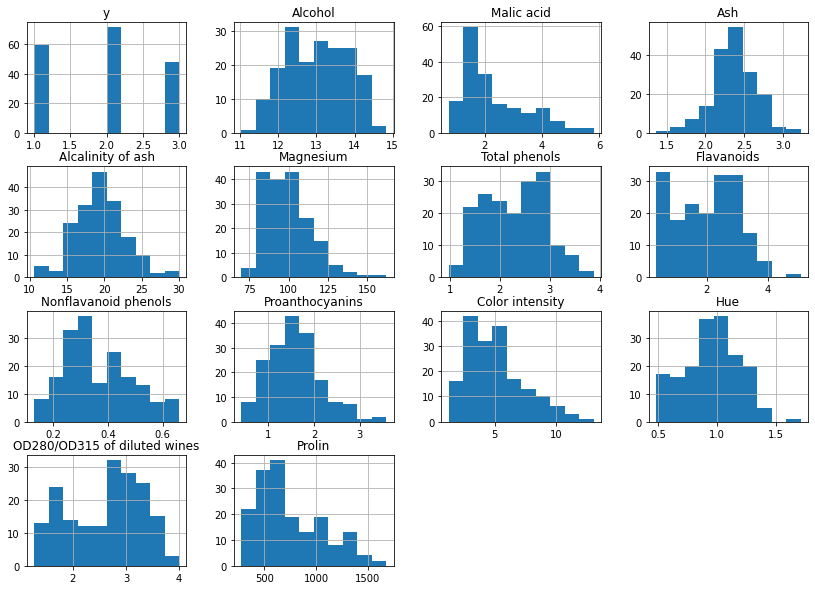

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Read data- provide visualization
df=pd.read_csv('wine.data',header=None)
df.columns = """y,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Prolin""".split(',')
df.hist(figsize=(14,10));
df.head()

In [29]:
from sklearn.preprocessing import scale

# Scale the data
X = scale(df.values[:,1:]) #zero mean and unit variance
y = df.values[:,0]


# Apply estimate_sne and estimate_tsne

################################
# Begin your code

target_perplexity = 50
num_iters=500
learning_rate=10
# why dont you fucking work
P = p_joint(X, target_perplexity)

Y_sne = estimate_sne(X, P, num_iters, learning_rate)
Y_tsne =  estimate_tsne(X, P, num_iters, learning_rate)
# End your code
################################


In [32]:
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA,FastICA
from sklearn import manifold

projection_methods = {
    'PCA' :
        PCA(n_components=2),
    'FastICA' : 
        FastICA(n_components=2),

#TODO: ADD YOUR PROJECTION METHODS
################################
# Begin your code
    
    # https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html
    'MDS' : 
        manifold.MDS(n_components=2),
    # https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html
    "LLE" :
        manifold.LocallyLinearEmbedding(n_components=2),
    # https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html
    "Isomap" : 
        manifold.Isomap(n_components=2)
    
# End your code
################################
}

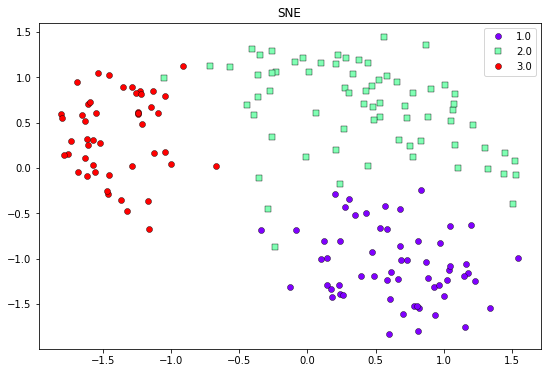

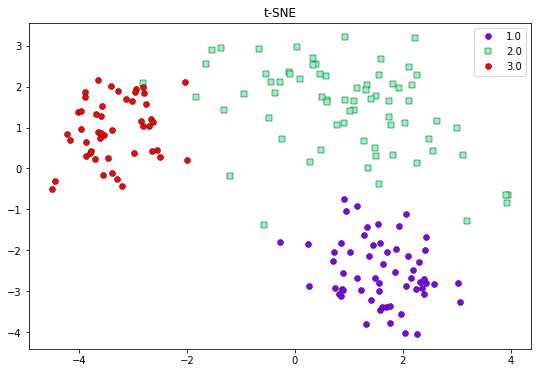

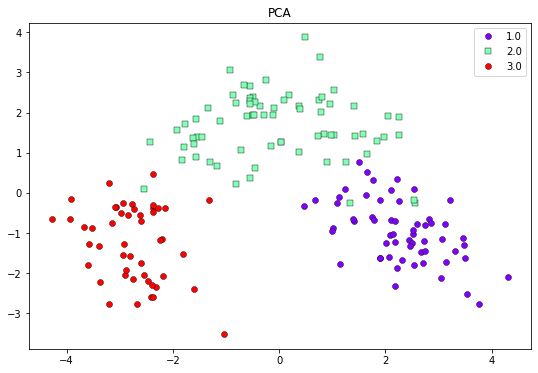

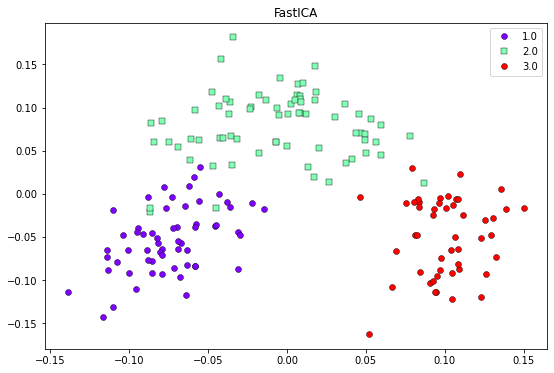

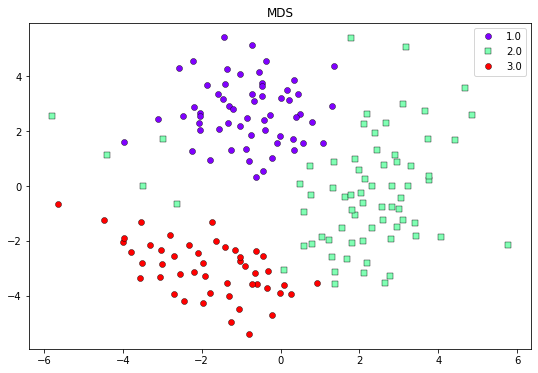

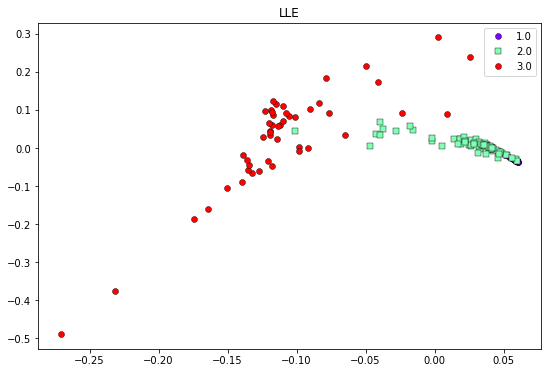

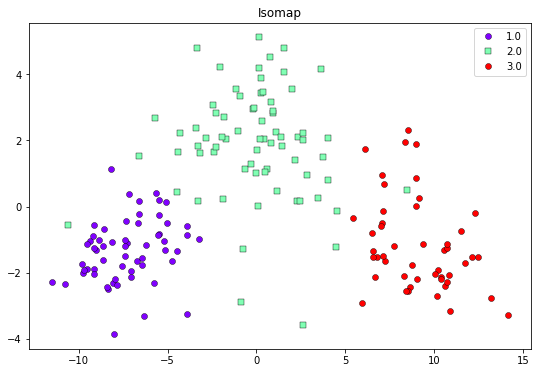

In [33]:
#TODO: VISUALIZE THE RESULTS
################################
# Begin your code
def categorical_scatter_2d(Y_calc, class_idxs, ms=3, ax=None, alpha=0.1, figsize=None):
    ## Plot a 2D matrix with corresponding class labels: each class diff colour
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    #ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    classes = list(np.unique(class_idxs))
    markers = 'os' * len(classes)
    colors = plt.cm.rainbow(np.linspace(0,1,len(classes)))

    for i, cls in enumerate(classes):
        mark = markers[i]
        ax.plot(Y_calc[class_idxs==cls, 0], Y_calc[class_idxs==cls, 1], marker=mark, 
            linestyle='', ms=ms, label=str(cls), alpha=alpha, color=colors[i],
            markeredgecolor='black', markeredgewidth=0.4)
    ax.legend()
    return ax

# f, axes = plt.subplots(1, 2, sharex=True)
categorical_scatter_2d(Y_sne, y, alpha=1.0, ms=6, figsize=(9, 6)).set_title("SNE")
categorical_scatter_2d(Y_tsne, y, alpha=1.0, ms=6, figsize=(9, 6)).set_title("t-SNE")

for i, (label, method) in enumerate(projection_methods.items()):
    Y = method.fit_transform(X)
    categorical_scatter_2d(Y, y, alpha=1.0, ms=6, figsize=(9, 6)).set_title(label)

# End your code
################################

<h3 style="color:rgb(210,90,80)">Question (5 points):</h3>

Using the results of your plots  you should now be able to digest which of the statements below are true. Thus tick the correct boxes (several may be correct):
    
\[  \]  Non-Metric MDS separates one group, the other two groups are overlapping. Metric MDS fails. <br>
\[  \]  LLE performs similarly to MDS: only one group is cleanly separated. <br>
\[  \]  Isomap does not provide any conclusive result, i.e. no group is clearly separated from the others. <br>
\[ X \]  t-SNE with reasonable perplexity settings does a very good job in separating all three groups, thus seems to be the better solution to overcome the crowding problem, compared to symmetric SNE and the other methods.<br>
\[  \]  The smaller the perplexity, the better the separation abilities of t-SNE.<br>